# Multi-Step Inference Analysis

Compare single-step results (already computed) with multi-step inference:
- **Single-step**: Load existing test results (baseline)
- **Multi-step**: Split instruction by connectors and execute sequentially

This experiment tests error propagation when chaining multiple tasks.

In [32]:
from pathlib import Path
import sys
import json
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.io import loadmat, savemat
import os
from tqdm import tqdm

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

TEXT_ENCODER_MODE = "llm"  # "clip" | "llm"
QWEN_MODEL_PATH = "/home/intern4/.cache/huggingface/hub/models--Qwen--Qwen2.5-0.5B-Instruct/snapshots/7ae557604adf67be50417f59c2c2f167def9a775"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

project_root = Path.cwd()
if project_root.name == 'visualize':
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Clear Jupyter's argv to avoid argparse conflicts
if hasattr(sys, 'argv'):
    original_argv = sys.argv.copy()
    sys.argv = [sys.argv[0]]

from datawrapper.datawrapper import _coerce_matlab_text, _normalize_tensor
from datawrapper.simple_tokenizer import SimpleTokenizer
from datawrapper.warpper_utils import interpolate_to_target_width, resize_512
from model.listfm_it import load_from_ckpt
from core_funcs import rectified_flow_sample
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

tokenizer = SimpleTokenizer()
qwen_tokenizer = None
if TEXT_ENCODER_MODE == "llm":
    from transformers import AutoTokenizer
    qwen_tokenizer = AutoTokenizer.from_pretrained(QWEN_MODEL_PATH, use_fast=True)
    print("Qwen tokenizer loaded")

print("device:", device)

Qwen tokenizer loaded
device: cuda


In [33]:
# Metric helpers (crop + skimage)
CROP_X1, CROP_X2, CROP_Y1, CROP_Y2 = 20, -20, 20, -20

def _crop_for_metric(img):
    return img[CROP_X1:CROP_X2, CROP_Y1:CROP_Y2]

def _psnr_ssim_crop(label_img, out_img):
    label_crop = _crop_for_metric(label_img)
    out_crop = _crop_for_metric(out_img)
    data_range = float(label_crop.max() - label_crop.min())
    if data_range == 0:
        return float('nan'), float('nan')
    psnr_val = psnr(label_crop, out_crop, data_range=data_range)
    ssim_val = ssim(label_crop, out_crop, data_range=data_range)
    return psnr_val, ssim_val


In [34]:
# Load model
# Multi-step model checkpoint
multi_run_idx = 23
multi_run_ep = 8

# Single-step results location (separate run)
single_run_idx = 28
single_run_ep = 12

ckpt_path = Path(f"/home/intern4/fm2026/fm_flow/code_it/logs/{multi_run_idx:05d}_train/checkpoints/checkpoint_{multi_run_ep}.ckpt")

if TEXT_ENCODER_MODE == "llm":
    model = load_from_ckpt(
        ckpt_path=ckpt_path,
        from_scratch=False,
        use_vision_decoder=True,
        use_vision_decoder_weights=True,
        qwen_model_path=QWEN_MODEL_PATH,
        qwen_lora_path=None,
        qwen_trainable=False,
    )
    print("with Qwen LLM instruction encoder")
else:
    model = load_from_ckpt(
        ckpt_path=ckpt_path,
        from_scratch=False,
        use_vision_decoder=True,
        use_vision_decoder_weights=True,
    )

model = model.to(device)
model.eval()
print("loaded", ckpt_path)


2026-02-19 00:03:48 [SUCCESS] Checkpoint loaded successfully.
2026-02-19 00:03:48 [DEBUG] Width check success
2026-02-19 00:03:48 [DEBUG] Head check success
2026-02-19 00:03:48 [DEBUG] BPE file exists.
2026-02-19 00:03:50 [DEBUG] QC start.
2026-02-19 00:03:50 [DEBUG] Image size: torch.Size([2, 1, 512, 512])
2026-02-19 00:03:50 [DEBUG] Text size: torch.Size([2, 1536])
2026-02-19 00:03:52 [DEBUG] img_full_feature size: torch.Size([2, 1025, 512])
2026-02-19 00:03:52 [DEBUG] text_full_feature size: torch.Size([2, 1536, 512])
2026-02-19 00:03:52 [DEBUG] img mean std max min: 0.0754 1.0398 4.6759 -3.5423
2026-02-19 00:03:52 [DEBUG] text mean std max min: 0.0848 1.1799 25.7172 -15.0051
2026-02-19 00:03:52 [DEBUG] stack_feature[0] size: torch.Size([2, 64, 512, 512])
2026-02-19 00:03:52 [DEBUG] stack_feature[1] size: torch.Size([2, 128, 256, 256])
2026-02-19 00:03:52 [DEBUG] stack_feature[2] size: torch.Size([2, 256, 128, 128])
2026-02-19 00:03:52 [DEBUG] stack_feature[3] size: torch.Size([2, 5

In [116]:
# Data paths
data_roots = [
    Path("/fast_storage/intern/data/instruction_tuning/multi_task/acceleration/test"),
    Path("/fast_storage/intern/data/instruction_tuning/multi_task/crossmodal/test"),
    # Path("/fast_storage/intern/data/instruction_tuning/multi_task/denoising_and_crossmodal/test"),
    # Path("/fast_storage/intern/data/instruction_tuning/multi_task/denoising_and_segmentation/test"),
]

# Check which paths exist and collect files
all_files = []
for data_root in data_roots:
    if data_root.exists():
        mat_files = sorted(data_root.glob("*.mat"))
        print(f"{data_root.name}: {len(mat_files)} files")
        all_files.extend([(f, data_root.name) for f in mat_files])
    else:
        print(f"{data_root.name}: NOT FOUND")

print(f"\nTotal files: {len(all_files)}")

test: 804 files
test: 804 files

Total files: 1608


In [117]:
# Helper function to perform single inference
def single_inference(model, img, text_raw, instr_raw, device):
    """Perform one inference pass."""
    text = tokenizer.tokenize(text_raw, context_length=1536).squeeze().unsqueeze(0).to(device)
    
    instruction_llm_ids = None
    instruction_llm_mask = None
    if TEXT_ENCODER_MODE == "llm":
        llm_inputs = qwen_tokenizer(
            instr_raw,
            padding="max_length",
            truncation=True,
            max_length=128,
            return_tensors="pt",
        )
        instruction_llm_ids = llm_inputs["input_ids"].squeeze(0).to(device).unsqueeze(0)
        instruction_llm_mask = llm_inputs["attention_mask"].squeeze(0).to(device).unsqueeze(0)
    
    instruction = tokenizer.tokenize(instr_raw, context_length=64).squeeze().unsqueeze(0).to(device)
    
    llm_kwargs = {}
    if TEXT_ENCODER_MODE == "llm":
        llm_kwargs = {
            "instruction_llm_ids": instruction_llm_ids,
            "instruction_llm_mask": instruction_llm_mask,
        }
    
    with torch.no_grad():
        out = rectified_flow_sample(
            model=model,
            img=img,
            text=text,
            instruction=instruction,
            **llm_kwargs
        )
    
    return out

In [118]:
# Connector-based instruction parsing
DEFAULT_CONNECTORS = [
    "and",
    "then",
    "after that",
    "and then",
    "afterwards",
    "and afterward",
    "followed by",
    "then after that",
]

def split_instruction_by_connector(instr_raw):
    """
    Split instruction into two parts based on connectors.
    Returns (instruction1, instruction2, connector_used)
    
    Examples:
    - "Denoise this MRI and convert from T1 to T2" 
      → ("Denoise this MRI", "convert from T1 to T2", "and")
    - "Reconstruct x4 undersampled data then segment the brain"
      → ("Reconstruct x4 undersampled data", "segment the brain", "then")
    """
    instr_lower = instr_raw.lower()
    
    # Try each connector (longest first to avoid partial matches)
    sorted_connectors = sorted(DEFAULT_CONNECTORS, key=len, reverse=True)
    
    for connector in sorted_connectors:
        # Look for connector surrounded by spaces or punctuation
        search_patterns = [
            f" {connector} ",
            f", {connector} ",
            f". {connector} ",
        ]
        
        for pattern in search_patterns:
            if pattern in instr_lower:
                # Find position in original (case-preserved) string
                idx = instr_lower.find(pattern)
                instr1 = instr_raw[:idx].strip().rstrip(',').rstrip('.')
                instr2_start = idx + len(pattern)
                instr2 = instr_raw[instr2_start:].strip()
                
                # Capitalize first letter of second instruction if needed
                if instr2 and instr2[0].islower():
                    instr2 = instr2[0].upper() + instr2[1:]
                
                return instr1, instr2, connector
    
    # If no connector found, return None
    return None, None, None


def parse_instruction(instr_raw):
    """
    Parse instruction and return two sub-instructions.
    """
    instr1, instr2, connector = split_instruction_by_connector(instr_raw)
    
    if instr1 is None or instr2 is None:
        return None, None, None
    
    return instr1, instr2, connector

In [119]:
# Load existing single-step results from test folder  
test_results_dir = Path(
    f"/home/intern4/fm2026/fm_flow/code_it/logs/{single_run_idx:05d}_train/test/ep_{single_run_ep}"
)

single_step_results = []  # list of dicts with: idx, res_file, instruction_raw

if test_results_dir.exists():
    result_files = sorted(test_results_dir.glob("*.mat"))
    print(f"Found {len(result_files)} existing test result files")
    
    for res_file in result_files:
        try:
            idx_str = res_file.stem.split("_res")[0]
            idx = int(idx_str)
        except Exception:
            continue
        try:
            res_data = loadmat(res_file)
            instr_raw = _coerce_matlab_text(res_data["instruction_raw"].squeeze())
        except Exception:
            instr_raw = None
        single_step_results.append({
            "idx": idx,
            "res_file": res_file,
            "instruction_raw": instr_raw,
        })
    
    print(f"Loaded {len(single_step_results)} single-step results")
else:
    print(f"WARNING: Test results not found at {test_results_dir}")
    single_step_results = []


Found 96 existing test result files
Loaded 96 single-step results


In [120]:
# Build instruction -> sample mapping (may take time)
from collections import defaultdict

def _safe_matlab_text(mat, key):
    try:
        arr = mat.get(key)
        if arr is None:
            return None
        # Handle empty arrays
        if getattr(arr, "size", 0) == 0:
            return None
        return _coerce_matlab_text(arr[0][0])
    except Exception:
        return None

def build_instruction_index(all_files):
    instr_index = defaultdict(list)
    for sample_file, dataset_name in all_files:
        try:
            data = loadmat(sample_file)
            instr_raw = _safe_matlab_text(data, "instruction")
            if instr_raw is None:
                continue
            instr_index[instr_raw].append((sample_file, dataset_name))
        except Exception:
            continue
    return instr_index


In [ ]:
# Test on a single sample
# Randomly pick a sample. Optionally require it to have a single-step result.
import random
require_single_step = False

sample_file = None
dataset_name = None
res_meta = None

if require_single_step:
    # Build index once
    instr_index = build_instruction_index(all_files)
    # Filter res files that have a matching instruction in current dataset
    candidates = [r for r in single_step_results if r["instruction_raw"] in instr_index]
    if not candidates:
        raise RuntimeError(
            "No single-step results match instruction_raw in current all_files. "
            "Check run_idx/ep or set require_single_step=False."
        )
    res_meta = random.choice(candidates)
    # If multiple samples share the same instruction, pick one at random
    sample_file, dataset_name = random.choice(instr_index[res_meta["instruction_raw"]])
else:
    sample_file, dataset_name = random.choice(all_files)

print(f"Testing on: {sample_file.name} from {dataset_name}")

data = loadmat(sample_file)
img = torch.from_numpy(data["image"]).unsqueeze(0).unsqueeze(0).float()
label = torch.from_numpy(data["label"]).unsqueeze(0).unsqueeze(0).float()

img = interpolate_to_target_width(img, target_size=512)
img = resize_512(img)
label = resize_512(interpolate_to_target_width(label, target_size=512))

img = _normalize_tensor(img)
label = _normalize_tensor(label)

text_raw = ""
instr_raw = _safe_matlab_text(data, "instruction")

print(f"Original instruction: {instr_raw}")

instr1, instr2, connector = parse_instruction(instr_raw)

if instr1 and instr2:
    print(f"Parsed instructions:")
    print(f"  Step 1: {instr1}")
    print(f"  Step 2: {instr2}")
    print(f"  Connector: '{connector}'")
else:
    print("Could not parse instruction into two steps")


Testing on: brats2023_gli_01529_t1_to_t2_s069_n01114.mat from test
Original instruction: Synthesize a representative T2-weighted brain slice from T1 imaging.
Could not parse instruction into two steps


In [113]:
# Perform multi-step inference
if instr1 and instr2:
    img_device = img.to(device)
    label_device = label.to(device)
    
    print("=" * 60)
    print("Multi-step inference")
    print("=" * 60)
    
    # Step 1 only
    print(f"Step 1: {instr1}")
    out_step1 = single_inference(model, img_device, text_raw, instr1, device)
    print(f"Step 1 output shape: {out_step1.shape}")
    
    # Step 2 applied to Step 1 output
    print(f"Step 2 (after Step 1): {instr2}")
    out_step2_after_step1 = single_inference(model, out_step1, text_raw, instr2, device)
    out_multi = out_step2_after_step1
    print(f"Step 2-after-Step1 output shape: {out_step2_after_step1.shape}")
    
    # Step 2 only (directly on original input)
    print(f"Step 2 (direct on input): {instr2}")
    out_step2_direct = single_inference(model, img_device, text_raw, instr2, device)
    print(f"Step 2-direct output shape: {out_step2_direct.shape}")
    
    # Quick sanity deltas
    delta_after = (out_step2_after_step1 - out_step1).abs().mean().item()
    delta_direct = (out_step2_direct - out_step1).abs().mean().item()
    print(f"Mean |Step2-after-Step1 - Step1|: {delta_after:.6f}")
    print(f"Mean |Step2-direct - Step1|: {delta_direct:.6f}")
    
    # Calculate metrics for multi-step (after Step 1)
    psnr_multi, ssim_multi = _psnr_ssim_crop(label.squeeze().cpu().numpy(), out_step2_after_step1.squeeze().detach().cpu().numpy())
    print(f"PSNR (Step2-after-Step1): {psnr_multi:.2f}, SSIM: {ssim_multi:.4f}")
    
    # Load single-step result if available (matched by instruction_raw)
    if res_meta is not None and res_meta.get("res_file") is not None:
        res_file = res_meta["res_file"]
        res_data = loadmat(res_file)
        out_single = torch.from_numpy(res_data["out"]).unsqueeze(0).unsqueeze(0).float().to(device)
        psnr_single, ssim_single = _psnr_ssim_crop(label.squeeze().cpu().numpy(), out_single.squeeze().detach().cpu().numpy())
        print(f"Single-step (from saved results):")
        print(f"PSNR: {psnr_single:.2f}, SSIM: {ssim_single:.4f}")
    else:
        print(f"No single-step result found for {sample_file.name}")
        out_single = None
        psnr_single = None
        ssim_single = None


Multi-step inference
Step 1: Reduce aliasing artifacts in this T2 brain MRI image (R=6)
Step 1 output shape: torch.Size([1, 1, 512, 512])
Step 2 (after Step 1): Generate a synthesized T1 representation of the brain from T2 input.
Step 2-after-Step1 output shape: torch.Size([1, 1, 512, 512])
Step 2 (direct on input): Generate a synthesized T1 representation of the brain from T2 input.
Step 2-direct output shape: torch.Size([1, 1, 512, 512])
Mean |Step2-after-Step1 - Step1|: 0.155336
Mean |Step2-direct - Step1|: 0.290405
PSNR (Step2-after-Step1): 25.13, SSIM: 0.9029
Single-step (from saved results):
PSNR: 25.20, SSIM: 0.9118


COMPARISON
Single-step - PSNR: 25.20, SSIM: 0.9118
Multi-step  - PSNR: 25.13, SSIM: 0.9029
Difference  - PSNR: +0.07, SSIM: +0.0089


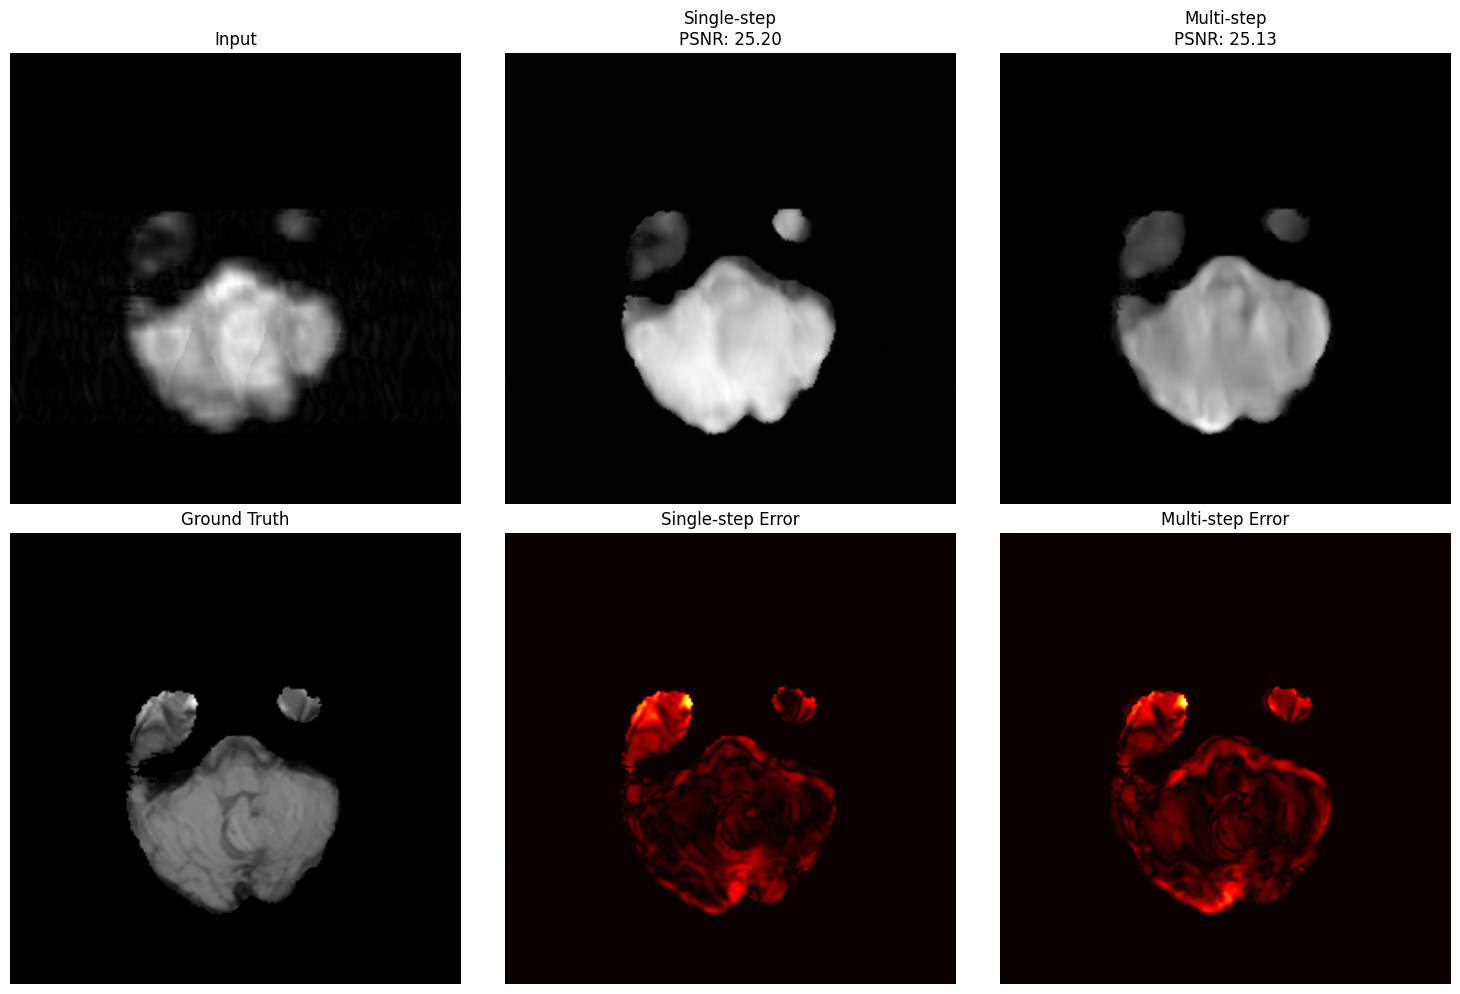

In [114]:
# Compare results
if out_single is not None:
    print("=" * 60)
    print("COMPARISON")
    print("=" * 60)
    print(f"Single-step - PSNR: {psnr_single:.2f}, SSIM: {ssim_single:.4f}")
    print(f"Multi-step  - PSNR: {psnr_multi:.2f}, SSIM: {ssim_multi:.4f}")
    print(f"Difference  - PSNR: {psnr_single - psnr_multi:+.2f}, SSIM: {ssim_single - ssim_multi:+.4f}")
    
    # Visualize
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Row 1: Images
    axes[0, 0].imshow(img.squeeze().cpu().numpy(), cmap='gray')
    axes[0, 0].set_title('Input')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(out_single.squeeze().detach().cpu().numpy(), cmap='gray')
    axes[0, 1].set_title(f'Single-step\nPSNR: {psnr_single:.2f}')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(out_step2_after_step1.squeeze().detach().cpu().numpy(), cmap='gray')
    axes[0, 2].set_title(f'Multi-step\nPSNR: {psnr_multi:.2f}')
    axes[0, 2].axis('off')
    
    # Row 2: Label and differences
    axes[1, 0].imshow(label.squeeze().cpu().numpy(), cmap='gray')
    axes[1, 0].set_title('Ground Truth')
    axes[1, 0].axis('off')
    
    diff_single = np.abs(label.squeeze().cpu().numpy() - out_single.squeeze().detach().cpu().numpy())
    axes[1, 1].imshow(diff_single, cmap='hot')
    axes[1, 1].set_title('Single-step Error')
    axes[1, 1].axis('off')
    
    diff_multi = np.abs(label.squeeze().cpu().numpy() - out_step2_after_step1.squeeze().detach().cpu().numpy())
    axes[1, 2].imshow(diff_multi, cmap='hot')
    axes[1, 2].set_title('Multi-step Error')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

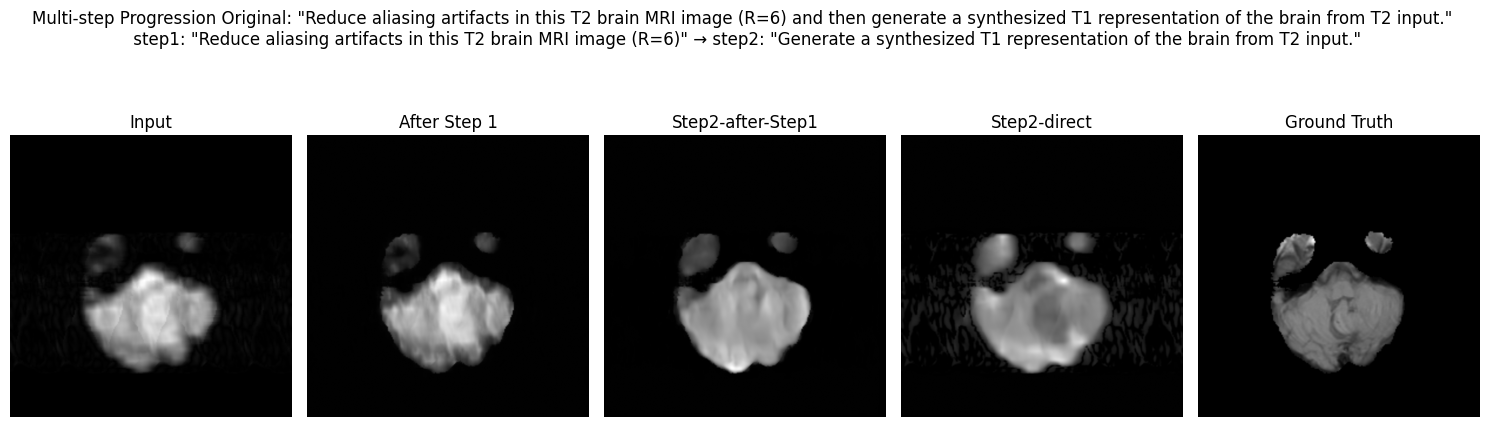

In [115]:
# Visualize intermediate step
if instr1 and instr2:
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    
    axes[0].imshow(img.squeeze().cpu().numpy(), cmap='gray')
    axes[0].set_title('Input')
    axes[0].axis('off')
    
    axes[1].imshow(out_step1.squeeze().detach().cpu().numpy(), cmap='gray')
    axes[1].set_title(f'After Step 1')
    axes[1].axis('off')
    
    axes[2].imshow(out_step2_after_step1.squeeze().detach().cpu().numpy(), cmap='gray')
    axes[2].set_title(f'Step2-after-Step1')
    axes[2].axis('off')

    axes[3].imshow(out_step2_direct.squeeze().detach().cpu().numpy(), cmap='gray')
    axes[3].set_title(f'Step2-direct')
    axes[3].axis('off')

    axes[4].imshow(label.squeeze().cpu().numpy(), cmap='gray')
    axes[4].set_title('Ground Truth')
    axes[4].axis('off')

   

    plt.suptitle(f'Multi-step Progression Original: "{instr_raw}" \n step1: "{instr1}" → step2: "{instr2}"')
    plt.tight_layout()
    plt.show()


In [ ]:
# Run multi-step inference on multiple samples
num_samples = 50  # Adjust as needed
results = {
    'single_step': {'psnr': [], 'ssim': []},
    'multi_step': {'psnr': [], 'ssim': []},
    'filenames': [],
    'instructions': [],
    'instr1': [],
    'instr2': []
}

print(f"Running multi-step inference on up to {num_samples} samples...")

# Build instruction index once for matching
instr_index = build_instruction_index(all_files)

processed_count = 0
for res_meta in single_step_results:
    if processed_count >= num_samples:
        break
    
    instr_raw = res_meta.get("instruction_raw")
    if instr_raw is None:
        continue
    if instr_raw not in instr_index:
        continue

    # Choose a sample that matches the instruction
    sample_file, dataset_name = random.choice(instr_index[instr_raw])
    
    try:
        data = loadmat(sample_file)
        img = torch.from_numpy(data["image"]).unsqueeze(0).unsqueeze(0).float()
        label = torch.from_numpy(data["label"]).unsqueeze(0).unsqueeze(0).float()
        
        img = interpolate_to_target_width(img, target_size=512)
        img = resize_512(img)
        label = resize_512(interpolate_to_target_width(label, target_size=512))
        
        img = _normalize_tensor(img)
        label = _normalize_tensor(label)
        
        text_raw = _safe_matlab_text(data, "text")
        instr_raw = _safe_matlab_text(data, "instruction")
        if text_raw is None or instr_raw is None:
            continue
        
        # Parse instruction
        instr1, instr2, connector = parse_instruction(instr_raw)
        if not instr1 or not instr2:
            continue
        
        img_device = img.to(device)
        label_device = label.to(device)
        
        # Load single-step result
        res_file = res_meta["res_file"]
        res_data = loadmat(res_file)
        out_single = torch.from_numpy(res_data["out"]).unsqueeze(0).unsqueeze(0).float().to(device)
        psnr_single, ssim_single = _psnr_ssim_crop(label.squeeze().cpu().numpy(), out_single.squeeze().detach().cpu().numpy())
        
        # Multi-step inference
        out_step1 = single_inference(model, img_device, text_raw, instr1, device)
        out_step1 = _normalize_tensor(out_step1)
        out_multi = single_inference(model, out_step1, text_raw, instr2, device)
        psnr_multi, ssim_multi = _psnr_ssim_crop(label.squeeze().cpu().numpy(), out_multi.squeeze().detach().cpu().numpy())
        
        # Store results
        results['single_step']['psnr'].append(psnr_single)
        results['single_step']['ssim'].append(ssim_single)
        results['multi_step']['psnr'].append(psnr_multi)
        results['multi_step']['ssim'].append(ssim_multi)
        results['filenames'].append(sample_file.name)
        results['instructions'].append(instr_raw)
        results['instr1'].append(instr1)
        results['instr2'].append(instr2)
        
        processed_count += 1
        
    except Exception as e:
        print(f"Error processing {sample_file.name}: {e}")
        continue

print(f"Successfully processed {len(results['filenames'])} samples")


SyntaxError: unterminated string literal (detected at line 81) (3035683771.py, line 81)

In [ ]:
# Analyze results
psnr_single = np.array(results['single_step']['psnr'])
ssim_single = np.array(results['single_step']['ssim'])
psnr_multi = np.array(results['multi_step']['psnr'])
ssim_multi = np.array(results['multi_step']['ssim'])

print("=" * 70)
print("OVERALL RESULTS")
print("=" * 70)
print(f"Single-step - PSNR: {psnr_single.mean():.2f} ± {psnr_single.std():.2f}")
print(f"              SSIM: {ssim_single.mean():.4f} ± {ssim_single.std():.4f}")
print()
print(f"Multi-step  - PSNR: {psnr_multi.mean():.2f} ± {psnr_multi.std():.2f}")
print(f"              SSIM: {ssim_multi.mean():.4f} ± {ssim_multi.std():.4f}")
print()
print(f"Difference  - PSNR: {(psnr_single - psnr_multi).mean():.2f} ± {(psnr_single - psnr_multi).std():.2f}")
print(f"              SSIM: {(ssim_single - ssim_multi).mean():.4f} ± {(ssim_single - ssim_multi).std():.4f}")

# Statistical test
from scipy.stats import ttest_rel
t_psnr, p_psnr = ttest_rel(psnr_single, psnr_multi)
t_ssim, p_ssim = ttest_rel(ssim_single, ssim_multi)
print()
print(f"Paired t-test:")
print(f"  PSNR: t={t_psnr:.3f}, p={p_psnr:.4f}")
print(f"  SSIM: t={t_ssim:.3f}, p={p_ssim:.4f}")

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PSNR comparison
axes[0].scatter(psnr_single, psnr_multi, alpha=0.6)
axes[0].plot([psnr_single.min(), psnr_single.max()], 
             [psnr_single.min(), psnr_single.max()], 
             'r--', label='Equal performance')
axes[0].set_xlabel('Single-step PSNR (dB)')
axes[0].set_ylabel('Multi-step PSNR (dB)')
axes[0].set_title('PSNR Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# SSIM comparison
axes[1].scatter(ssim_single, ssim_multi, alpha=0.6)
axes[1].plot([ssim_single.min(), ssim_single.max()], 
             [ssim_single.min(), ssim_single.max()], 
             'r--', label='Equal performance')
axes[1].set_xlabel('Single-step SSIM')
axes[1].set_ylabel('Multi-step SSIM')
axes[1].set_title('SSIM Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Break down by task pair (based on parsed instructions)
task_breakdown = defaultdict(lambda: {'single_psnr': [], 'single_ssim': [], 
                                       'multi_psnr': [], 'multi_ssim': []})

for i in range(len(results['filenames'])):
    # Create task key from instr1 and instr2
    task_key = f"{results['instr1'][i][:30]}... → {results['instr2'][i][:30]}..."
    task_breakdown[task_key]['single_psnr'].append(results['single_step']['psnr'][i])
    task_breakdown[task_key]['single_ssim'].append(results['single_step']['ssim'][i])
    task_breakdown[task_key]['multi_psnr'].append(results['multi_step']['psnr'][i])
    task_breakdown[task_key]['multi_ssim'].append(results['multi_step']['ssim'][i])

print("=" * 70)
print("BREAKDOWN BY INSTRUCTION PAIR")
print("=" * 70)

for task_pair, metrics in sorted(task_breakdown.items()):
    n = len(metrics['single_psnr'])
    single_psnr_mean = np.mean(metrics['single_psnr'])
    single_ssim_mean = np.mean(metrics['single_ssim'])
    multi_psnr_mean = np.mean(metrics['multi_psnr'])
    multi_ssim_mean = np.mean(metrics['multi_ssim'])
    
    print(f"\n{task_pair} (n={n}):")
    print(f"  Single - PSNR: {single_psnr_mean:.2f}, SSIM: {single_ssim_mean:.4f}")
    print(f"  Multi  - PSNR: {multi_psnr_mean:.2f}, SSIM: {multi_ssim_mean:.4f}")
    print(f"  Δ      - PSNR: {single_psnr_mean - multi_psnr_mean:+.2f}, SSIM: {single_ssim_mean - multi_ssim_mean:+.4f}")

In [ ]:
# Save results
output_dir = Path(f"/home/intern4/fm2026/fm_flow/code_it/logs/{multi_run_idx:05d}_train/multi_step_comparison")
output_dir.mkdir(parents=True, exist_ok=True)

# Save detailed results
results_dict = {
    'multi_run_idx': multi_run_idx,
    'multi_run_ep': multi_run_ep,
    'single_run_idx': single_run_idx,
    'single_run_ep': single_run_ep,
    'num_samples': len(results['filenames']),
    'overall': {
        'single_step': {
            'psnr_mean': float(psnr_single.mean()),
            'psnr_std': float(psnr_single.std()),
            'ssim_mean': float(ssim_single.mean()),
            'ssim_std': float(ssim_single.std()),
        },
        'multi_step': {
            'psnr_mean': float(psnr_multi.mean()),
            'psnr_std': float(psnr_multi.std()),
            'ssim_mean': float(ssim_multi.mean()),
            'ssim_std': float(ssim_multi.std()),
        },
        'difference': {
            'psnr_mean': float((psnr_single - psnr_multi).mean()),
            'psnr_std': float((psnr_single - psnr_multi).std()),
            'ssim_mean': float((ssim_single - ssim_multi).mean()),
            'ssim_std': float((ssim_single - ssim_multi).std()),
        },
        'ttest': {
            'psnr_t': float(t_psnr),
            'psnr_p': float(p_psnr),
            'ssim_t': float(t_ssim),
            'ssim_p': float(p_ssim),
        }
    },
    'per_sample': {
        'filenames': results['filenames'],
        'instructions': results['instructions'],
        'instr1': results['instr1'],
        'instr2': results['instr2'],
        'single_step_psnr': [float(x) for x in results['single_step']['psnr']],
        'single_step_ssim': [float(x) for x in results['single_step']['ssim']],
        'multi_step_psnr': [float(x) for x in results['multi_step']['psnr']],
        'multi_step_ssim': [float(x) for x in results['multi_step']['ssim']],
    }
}

with open(output_dir / 'results.json', 'w') as f:
    json.dump(results_dict, f, indent=2)

print(f"Results saved to: {output_dir / 'results.json'}")
